In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from itertools import count
from collections import namedtuple, deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Initializing logging

In [2]:
import logging
import sys

# Create a custom log formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Configure logging with custom format and file output
logging.basicConfig(filename='./logs/app.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [54]:
filename = "EURUSD_M1_2023.csv"

df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
# data = df.resample('5min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

df = df.iloc[:10]

data = df.copy()
#Drop NA rows
data = data.dropna(axis=0)

print(data.head(10))
print(data.describe())

                        open     high      low    close
timestamp                                              
2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
            open       high        low      close
count  10.000000  10.000000  10.000000  10.000000
mean    1.069410   1.069429   1.069217   1.069217
std     0.000871   0.000879   0.000751   0.000751
min     1.067880   1.067880   1.067880   1.067880
25%     1.069443   1.069443   1.069035   1.069035
50%     1.069710   1.069730 

In [55]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Env

In [56]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

import random



class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(Enum):
    Short = 0
    Long = 1
    Hold = 2

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        # logging.debug("Trading Env init.")
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode
        self._done = False
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        # logging.debug("Trading Env reset.")
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1

        self._position = Positions.Short
        # logging.debug("Last tick  ", self._last_trade_tick)

        # self._position = self.get_position(seed)
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        if self._current_tick == self._end_tick:
            self._done = True

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        # logging.debug("Trading Env step.")
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        # print("Updating profit")

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()
        


        return observation, step_reward, self._done, self._truncated, info

    def _get_info(self):
        # logging.debug("Trading Env get info.")
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )
    #return a random position
    # def get_position(seed=None):
    #     logging.debug("Trading Env get position.")
    #     if seed is not None:
    #         random.seed(seed)

    #     return random.choice(list(Positions))

    def _get_observation(self):
        # logging.debug("Trading Env get observation.")
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        # logging.debug("Trading Env uodate history.")
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        # logging.debug("Trading Env Render.")

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        # logging.debug("Trading Env render all.")
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError


In [57]:
import numpy as np

# from .TradingEnv import TradingEnv, Actions, Positions


class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left', render_mode=None):
        # logging.debug("Forex Env init.")
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size, render_mode)

        self.trade_fee = 0.0003  # unit

    def _process_data(self):
        # logging.debug("Forex Env process data.")
        prices = self.df.loc[:, 'close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        # logging.debug("Forex Env calculate reward.")
        step_reward = 0  # pip

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            if self._current_tick < len(self.prices):  # Check if current_tick is within bounds
                current_price = self.prices[self._current_tick]
                last_trade_price = self.prices[self._last_trade_tick]
                price_diff = current_price - last_trade_price

                if self._position == Positions.Short:
                    step_reward += -price_diff * 10000
                elif self._position == Positions.Long:
                    step_reward += price_diff * 10000

        return step_reward



    def _update_profit(self, action):
        # logging.debug("Forex Env Update profit.")
        trade = False
        # print("Updating profit with action: ", action)

        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            if 0 <= self._current_tick < len(self.prices) and 0 <= self._last_trade_tick < len(self.prices):
                current_price = self.prices[self._current_tick]
                last_trade_price = self.prices[self._last_trade_tick]

                if self.unit_side == 'left':
                    if self._position == Positions.Short:
                        quantity = self._total_profit * (last_trade_price - self.trade_fee)
                        self._total_profit = quantity / current_price

                elif self.unit_side == 'right':
                    if self._position == Positions.Long:
                        quantity = self._total_profit / last_trade_price
                        self._total_profit = quantity * (current_price - self.trade_fee)

    def max_possible_profit(self):
        # logging.debug("Forex Env max posssible progit.")
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit


### Alternative Trading envionment

In [58]:
# from envs import ForexEnv, Actions


window_size = 1
start_index = window_size
end_index = len(data)
# len(data)

env  = ForexEnv(
    df= data,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [49]:
# from stable_baselines3 import DQN
# import torch.optim as optim

# learning_rate = 0.01
# optimizer = optim.Adam

# model = DQN(
#     "MlpPolicy",
#     env = env,
#     buffer_size=10000, 
#     batch_size = 32,
#     train_freq = 32,
#     gradient_steps = 32,
#     target_update_interval = 32,
#     learning_rate=learning_rate,
#     verbose=1,
#     device=device,
# )
# model.learn(total_timesteps=10, log_interval=10)
# model

In [60]:
import torch
import torch.nn as nn
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

def epsilon_greedy_policy(model, epsilon, num_actions, device):
    def policy_fn(state_info):
        state_array = state_info[0] if isinstance(state_info, tuple) else state_info  # Extract the array from the tuple if needed
        state_tensor = torch.tensor(state_array, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            q_values = model(state_tensor)
        
        if q_values.numel() == 0:  # Check if q_values tensor is empty
            return np.random.choice(num_actions)
        else:
            return torch.argmax(q_values).item()
    return policy_fn


def train_dqn(env, model, target_model, optimizer, gamma, batch_size, device, epsilon):
    state_info = env.reset()  # Ensure env.reset() returns a tuple (state, info) or just the state
    episode_reward = 0
    done = False
    
    while not done:
        action = epsilon_greedy_policy(model, epsilon, env.action_space.n, device)(state_info)
        step_result = env.step(action)
        # print("step_result: ",step_result)
        next_state, reward, done, truncate, info = step_result[:5]  # Extract the first four values
        episode_reward += reward
        
        # # print("Shapes before converting to PyTorch tensors:")
        # if isinstance(state_info, tuple) and len(state_info) == 2:
        #     print("state shape:", state_info[0].shape)  # Access the state from the state_info tuple
        # else:
        #     print("state shape:", state_info.shape)  # If state_info is not a tuple, assume it's the state itself
        
        # print("next_state:", next_state)
        # print("action:", action)
        print("reward:", reward)
        print("info:", info)
        
        # if len(next_state) > 0:  # Check if next_state is not empty
        #     print("next_state shape:", next_state[0].shape)
        # else:
        #     print("next_state is empty")
        
        # print("done:", done)

        done = done or truncate

        state_info = next_state  # Update state_info
        
    return episode_reward


# Parameters
input_dim = 2  # Adjusted input dimensions
output_dim = env.action_space.n
gamma = 0.99
batch_size = 32
epsilon = 0.1
lr = 1e-3
target_update = 10
num_episodes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize DQN and target DQN
model = DQN(input_dim, output_dim).to(device)
target_model = DQN(input_dim, output_dim).to(device)
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for episode in range(num_episodes):
    # print(episode)
    episode_reward = train_dqn(env, model, target_model, optimizer, gamma, batch_size, device, epsilon)
    
    if episode % target_update == 0:
        target_model.load_state_dict(model.state_dict())
        target_model.eval()
    
    if episode % 100 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

# After training, you can use the model for inference as needed


reward: 0.0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
Episode 0, Reward: 0.0
reward: 0.0
info: {'total_reward': 0.0, 'total_profit': 0.9997195475373927, 'position': <Positions.Long: 1>}
reward: 0


In [51]:
torch.save(model.state_dict(), './results/dqn_model_10000ep.pth')

In [15]:
# from stable_baselines3 import DQN
# import torch.optim as optim

# learning_rate = 0.01
# optimizer = optim.Adam

# model = DQN(
#     "MlpPolicy",
#     env = env,
#     buffer_size=10000, 
#     batch_size = 32,
#     train_freq = 32,
#     gradient_steps = 32,
#     target_update_interval = 32,
#     learning_rate=learning_rate,
#     verbose=1,
#     device=device,
# )
# model.learn(total_timesteps=10, log_interval=10)
# model

# #initial state
# action_stats = {Actions.Sell: 0, Actions.Buy: 0, Actions.Hold: 0}

# observation, info = env.reset()

# episode = 10
# for i in range(episode):
#     action = env.action_space.sample()
#     action,  _states = model.predict(observation)

#     print(action, _states, )

#     action_stats[Actions(action)] += 1
#     observation, reward, terminated, truncated, info = env.step(action)

#     # print("observation:", observation)
#     print("reward:", reward)
#     # print("terminated:", terminated)
#     # print("truncated:", truncated)
#     print("info:", info)

#     done = terminated or truncated
#     # env.render()

#     # env.render()
#     if done:
#         break

# env.close()

# print("action_stats:", action_stats)
# print("info:", info)
# # print("Trades:", env.unwrapped.)


In [61]:
# model.save("dqn_stable_baseline3_eurusd_2023_1M")

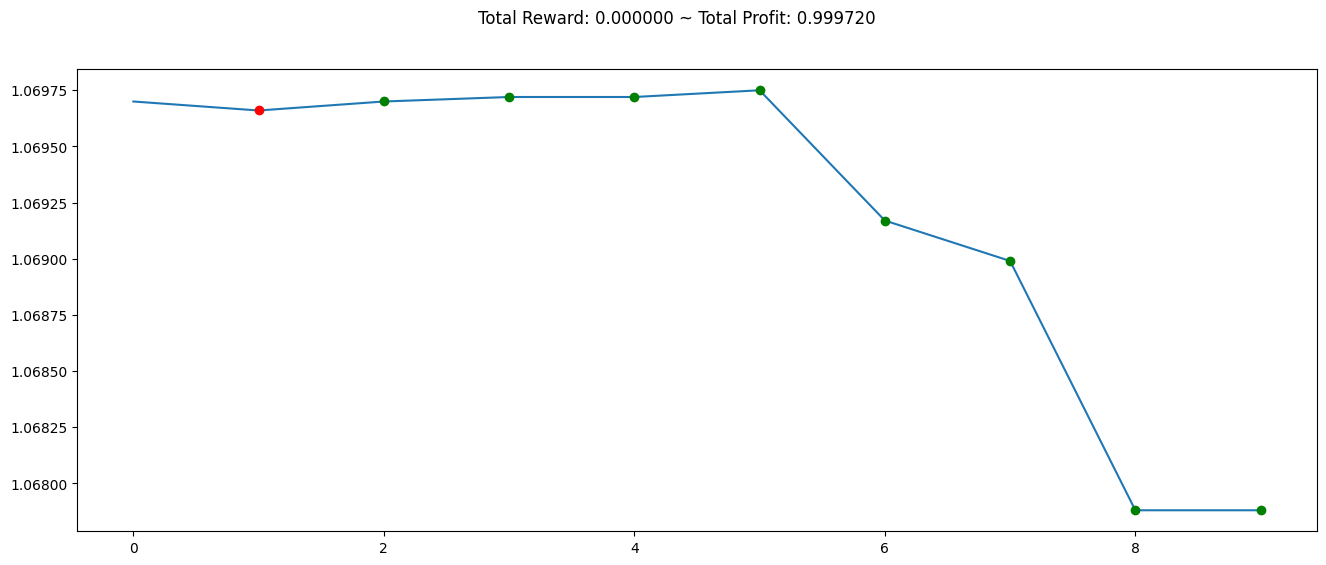

In [62]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [ ]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns)

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')

ValueError: Length of values (45) does not match length of index (89)